# Preliminaries

Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
from pathlib import Path

random_seed = 131313 # for reproducibility
precomputed_rules_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_race_atomic.data"
precomputed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_race_cumulative.data"

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [4]:
def make_binary(val):
    if val in [" Amer-Indian-Eskimo", " Asian-Pac-Islander", " Black", " Other"]:
        return " Non-White"
    elif val == " White":
        return val
    else:
        raise NotImplementedError("Code should be unreachable")

df.race = df.race.map(make_binary)

## Model training and test

In [5]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 2.8 s
Wall time: 4.59 s


array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [7]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.73      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



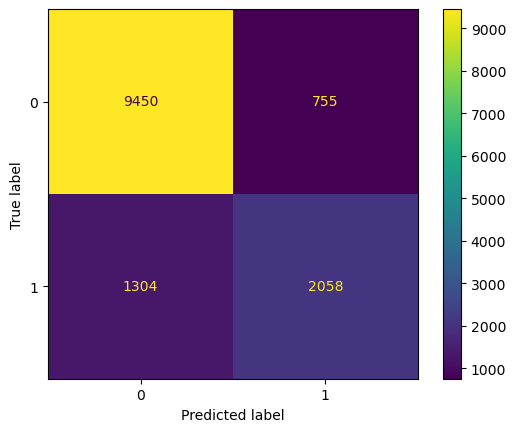

In [8]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [10]:
start_time = time.time()
ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='race',
    freqitem_minsupp=0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible=True,
    drop_above=True
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

Number of frequent itemsets for affected: {' Non-White': 24664, ' White': 27767}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 24664/24664 [00:00<00:00, 405959.85it/s]


Number of subgroups in the intersection: 18692
Number of frequent itemsets for the unaffected: 56394
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████████████████████████████████████████████████████████████████████| 18692/18692 [00:02<00:00, 6368.82it/s]


Computing correctenesses for all valid if-thens.


100%|██████████████████████████████████████████████████████████████████████████| 112879/112879 [24:39<00:00, 76.28it/s]


Number of if-thens: 112879


In [12]:
stats["triples-no"] = len(ifthens_coverage_correctness)
stats["subgroup-no"] = len(rules_by_if)
stats["valid-if-thens-time"] = end_time - start_time

In [11]:
## Use this for loading rules from disk
rules_by_if = load_rules_by_if(precomputed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

If you have `scikit-learn` version 1.0.2 installed, you can also run the below cell to load, additionally to rules, the model and test data we used.

In [12]:
# from facts.utils import load_object, save_object

# ## Use this if you wish to load state (model, X_test, rules) from disk
# (rules_by_if, X_test, model) = load_object(precomputed_rules_file)

# ## Use this if you wish to save state (model, X_test, rules) on disk
# # save_object(precomputed_rules_file, (rules_by_if, X_test, model))

In [13]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

We continue with the rankings and selection of rules according to each of the proposed metrics.

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [16]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (26.0, 34.0], education-num = 13, marital-status =  Never-married, sex =  Male:
	Protected Subgroup ' Non-White', 1.27% covered out of 1727
		Make age = (41.0, 50.0], education-num = 15, marital-status =  Married-civ-spouse with effectiveness 68.18%.
		Aggregate cost of the above recourses = 21.00
	Protected Subgroup ' White', 1.07% covered out of 9027
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with effectiveness 53.61%.
		Aggregate cost of the above recourses = 15.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 6.
If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, education-num = 10, native-country =  United-States, relationship =  Married:
	Protected Subgroup ' Non-White', 1.04% covered out of 1727
		Make age = (41.0, 50.0] with effectiveness 55.56%.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' White', 1.87% covered out of 9027
		Make age = (34.0, 41.0], education-num = 12 with effectiveness 57.

### Equal Choice for Recourse

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, hours-per-week = PartTime, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 1.33% covered out of 1727
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime with effectiveness 21.74%.
		Make Workclass =  Federal-gov, hours-per-week = OverTime with effectiveness 34.78%.
		Aggregate cost of the above recourses = -2.00
	Protected Subgroup ' White', 1.56% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 38.30%.
		Make hours-per-week = FullTime with effectiveness 26.95%.
		Make hours-per-week = BrainDrain with effectiveness 38.30%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime with effectiveness 46.81%.
		Make Workclass =  Local-gov, hours-per-week = FullTime with effectiveness 21.99%.
		Make Workclass =  Federal-gov, hours-per-week = FullTime with effectiveness 38.30%.
		Make Workclass =  Self-emp-not-inc, hours-per-week = OverTime with effectiveness 25.53%.
		Make Workclass =  Self-emp-inc, hours-per

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [14]:
start_time = time.time()
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)
end_time = time.time()

100%|████████████████████████████████████████████████████████████████████████████| 15672/15672 [11:34<00:00, 22.57it/s]


In [15]:
stats["cumulative-time"] = end_time - start_time

In [19]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(precomputed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If Workclass =  Private, education-num = 9, hours-per-week = FullTime, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 4.00% covered out of 1727
		Make relationship =  Married with effectiveness 1.45% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 1.45% and counterfactual cost = 7.0.
		Make education-num = 10, relationship =  Married with effectiveness 1.45% and counterfactual cost = 8.0.
		Make education-num = 10, hours-per-week = OverTime, relationship =  Married with effectiveness 1.45% and counterfactual cost = 10.0.
		Make education-num = 11, relationship =  Married with effectiveness 1.45% and counterfactual cost = 11.0.
		Make education-num = 10, hours-per-week = BrainDrain, relationship =  Married with effectiveness 1.45% and counterfactual cost = 12.0.
		Make education-num = 11, hours-per-week = OverTime, relationship =  Married with effectiveness 1.45% and counterfactual cost = 13.0.
		Aggregate cost of

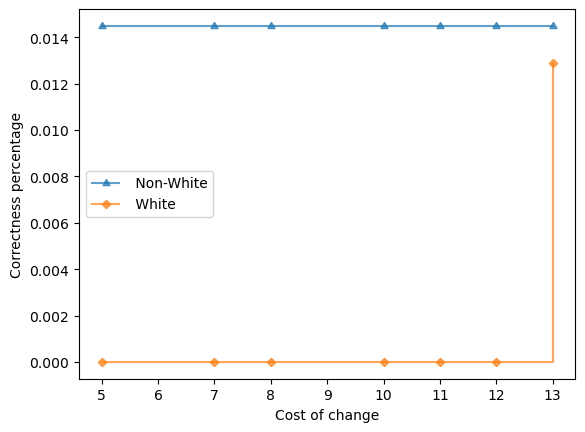

If capital-gain = 0, education-num = 10, marital-status =  Never-married, occupation =  Sales:
	Protected Subgroup ' Non-White', 1.45% covered out of 1727
		Make marital-status =  Married-civ-spouse with effectiveness 4.00% and counterfactual cost = 5.0.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial with effectiveness 4.00% and counterfactual cost = 9.0.
		Make education-num = 11, marital-status =  Married-civ-spouse, occupation =  Exec-managerial with effectiveness 4.00% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' White', 1.66% covered out of 9027
		Make marital-status =  Married-civ-spouse with effectiveness 0.00% and counterfactual cost = 5.0.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 9.0.
		Make education-num = 11, marital-status =  Married-civ-spouse, occupation =  Exec-managerial with effectiveness 1.33% and coun

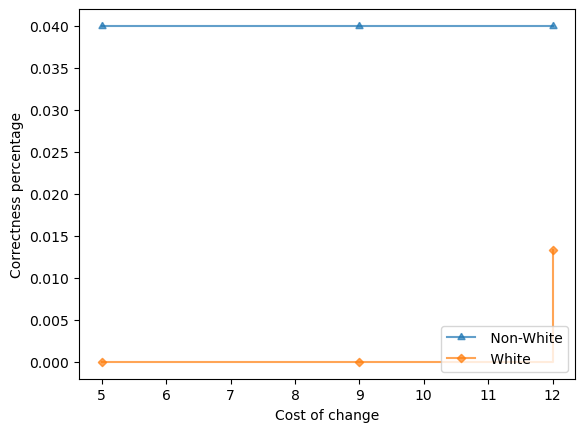

If capital-loss = 0, education-num = 9, hours-per-week = FullTime, relationship =  Not-in-family, sex =  Male:
	Protected Subgroup ' Non-White', 3.24% covered out of 1727
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 0.00% and counterfactual cost = 7.0.
		Make education-num = 10, relationship =  Married with effectiveness 0.00% and counterfactual cost = 8.0.
		Make hours-per-week = BrainDrain, relationship =  Married with effectiveness 0.00% and counterfactual cost = 9.0.
		Make education-num = 10, hours-per-week = OverTime, relationship =  Married with effectiveness 0.00% and counterfactual cost = 10.0.
		Make education-num = 11, relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make education-num = 10, hours-per-week = BrainDrain, relationship =  Married with effectiveness 0.00% and counterfactual cost = 12.0.
		Make education-num = 11

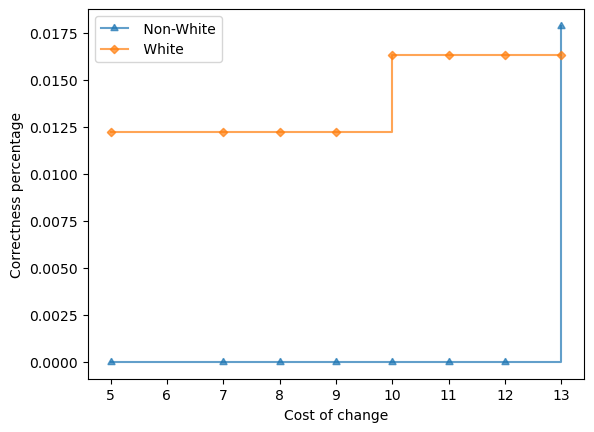

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 7.99% covered out of 1727
		Make marital-status =  Married-civ-spouse with effectiveness 0.72% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 0.72% and counterfactual cost = 7.0.
		Make education-num = 10, marital-status =  Married-civ-spouse with effectiveness 0.72% and counterfactual cost = 8.0.
		Make education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 0.72% and counterfactual cost = 10.0.
		Make education-num = 11, marital-status =  Married-civ-spouse with effectiveness 0.72% and counterfactual cost = 11.0.
		Make education-num = 10, hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with effectiveness 0.72% and counterfactual cost = 12.0.
		Make education-num = 11, hours-per-week = OverTime

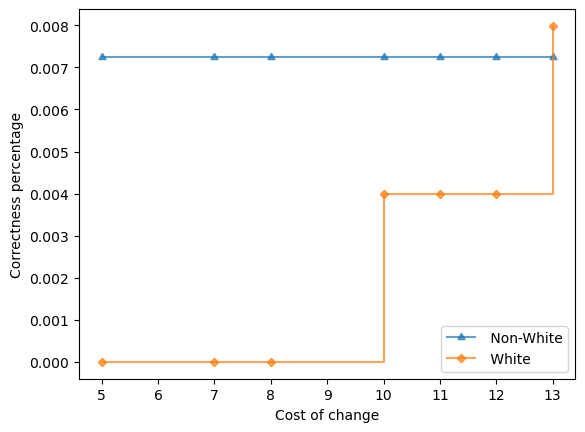

If capital-gain = 0, education-num = 9, native-country =  United-States, relationship =  Other-relative:
	Protected Subgroup ' Non-White', 2.20% covered out of 1727
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make education-num = 10, relationship =  Married with effectiveness 0.00% and counterfactual cost = 8.0.
		Make education-num = 11, relationship =  Married with effectiveness 2.63% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' White', 1.07% covered out of 9027
		Make relationship =  Married with effectiveness 1.03% and counterfactual cost = 5.0.
		Make education-num = 10, relationship =  Married with effectiveness 1.03% and counterfactual cost = 8.0.
		Make education-num = 11, relationship =  Married with effectiveness 1.03% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 5.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 6.0.
	Cu

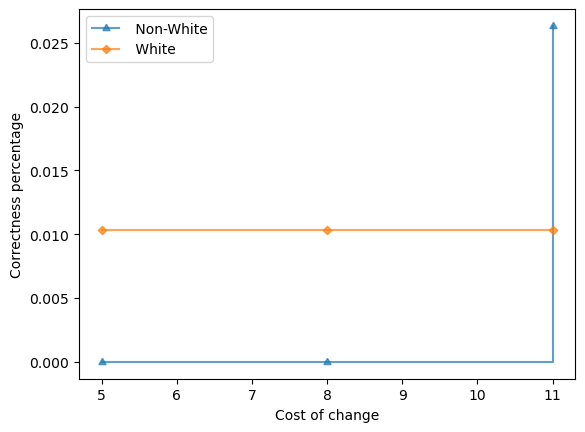

If Workclass =  Private, hours-per-week = FullTime, occupation =  Adm-clerical, relationship =  Own-child:
	Protected Subgroup ' Non-White', 1.68% covered out of 1727
		Make relationship =  Married with effectiveness 3.45% and counterfactual cost = 5.0.
		Make occupation =  Exec-managerial, relationship =  Married with effectiveness 3.45% and counterfactual cost = 9.0.
		Make occupation =  Prof-specialty, relationship =  Married with effectiveness 3.45% and counterfactual cost = 9.0.
		Make occupation =  Craft-repair, relationship =  Married with effectiveness 3.45% and counterfactual cost = 9.0.
		Make occupation =  Sales, relationship =  Married with effectiveness 3.45% and counterfactual cost = 9.0.
		Make occupation =  Tech-support, relationship =  Married with effectiveness 3.45% and counterfactual cost = 9.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial, relationship =  Married with effectiveness 3.45% and counterfactual cost = 11.0.
		Make hours-per-week = Ove

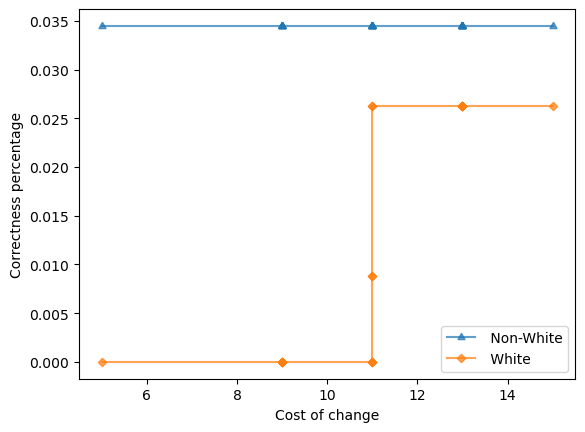

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Non-White', 1.39% covered out of 1727
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Adm-clerical with effe

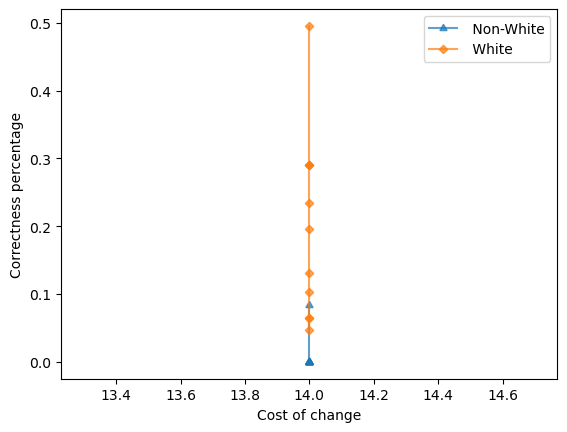

If Workclass =  Self-emp-not-inc, capital-loss = 0, native-country =  United-States, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.04% covered out of 1727
		Make Workclass =  Local-gov with effectiveness 5.56% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 5.56% and counterfactual cost = 2.0.
		Make Workclass =  Private with effectiveness 11.11% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 22.22% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 22.22% and counterfactual cost = 2.0.
		Make Workclass =  Private, capital-loss = 1887 with effectiveness 33.33% and counterfactual cost = 2.43.
		Make Workclass =  Private, capital-loss = 1902 with effectiveness 33.33% and counterfactual cost = 2.44.
		Make Workclass =  Private, capital-loss = 1977 with effectiveness 33.33% and counterfactual cost = 2.45.
		Make Workclass =  Private, relationship =  Not-in-family w

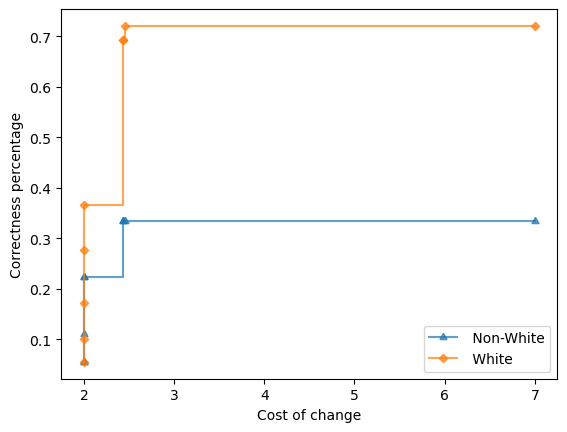

If education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Non-White', 1.51% covered out of 1727
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.69% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 9.0.
		Make education-num = 10, hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 11.0.
		Aggregate cost of the above

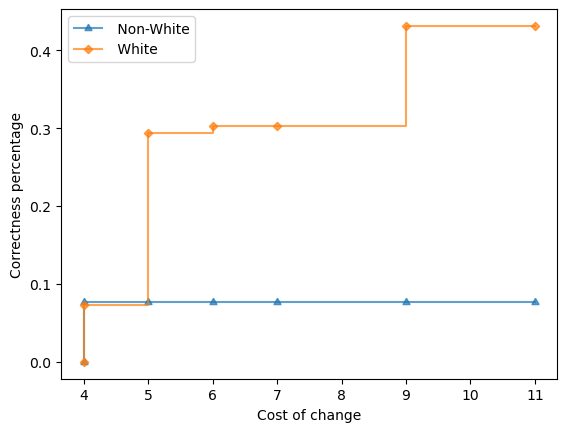

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, marital-status =  Divorced, native-country =  United-States, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 1.33% covered out of 1727
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.04% and counterfactual cost = 20.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.04% and counterfactual cost = 20.0.
		Make Workclass =  Self-emp-not-inc, age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.04% and counterfactual cost = 22.0.
		Make Workclass =  Self-emp-not-inc, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.04% and counterfactual cost = 22.0.
		Make Workclass =  State-gov, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.04% 

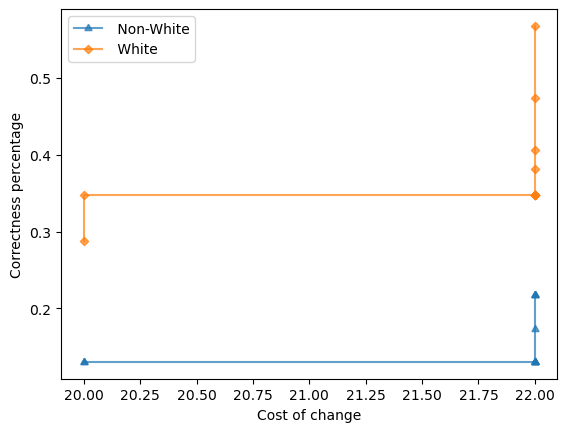

If age = (34.0, 41.0], education-num = 9, hours-per-week = FullTime, relationship =  Married:
	Protected Subgroup ' Non-White', 1.62% covered out of 1727
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], hours-per-week = OverTime with effectiveness 0.00% and counterfactual cost = 12.0.
		Make age = (50.0, 90.0], hours-per-week = OverTime with effectiveness 0.00% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], education-num = 10 with effectiveness 0.00% and counterfactual cost = 13.0.
		Make age = (50.0, 90.0], education-num = 10 with effectiveness 0.00% and counterfactual cost = 13.0.
		Make age = (50.0, 90.0], education-num = 10, hours-per-week = OverTime with effectiveness 0.00% and counterfactual cost = 15.0.
		Make age = (41.0, 50.0], education-num = 10, hours-per-week = OverTime with effectiveness 3.57% and counterfactual cost = 

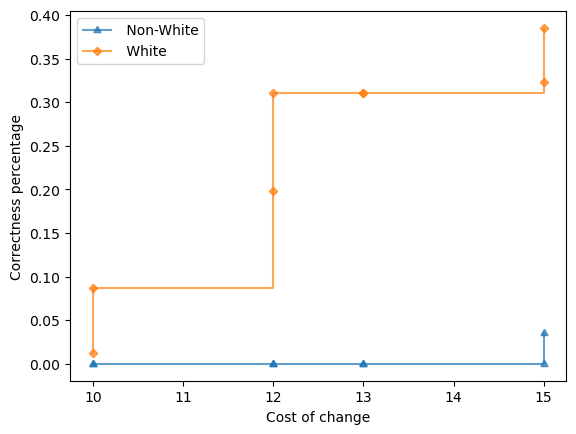

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 4.92% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.35% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.35% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.06% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 7.06% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 7.06% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 17.65% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.18
	Protected Subgroup ' White', 6.00% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.07% and counterfactual cost = 2.0.
		Make education-num = 10 with effect

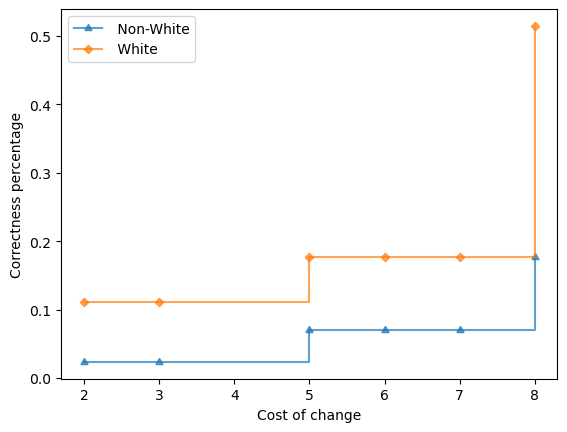

If hours-per-week = PartTime, native-country =  United-States, relationship =  Married:
	Protected Subgroup ' Non-White', 1.22% covered out of 1727
		Make hours-per-week = MidTime with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime with effectiveness 4.76% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain with effectiveness 4.76% and counterfactual cost = 8.0.
		Make hours-per-week = FullTime, relationship =  Not-in-family with effectiveness 4.76% and counterfactual cost = 9.0.
		Make hours-per-week = OverTime, relationship =  Not-in-family with effectiveness 4.76% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 0.05
	Protected Subgroup ' White', 2.45% covered out of 9027
		Make hours-per-week = MidTime with effectiveness 17.65% and counterfactual cost = 2.0.
		Make hours-per-week = FullTime with effectiveness 29.41% and

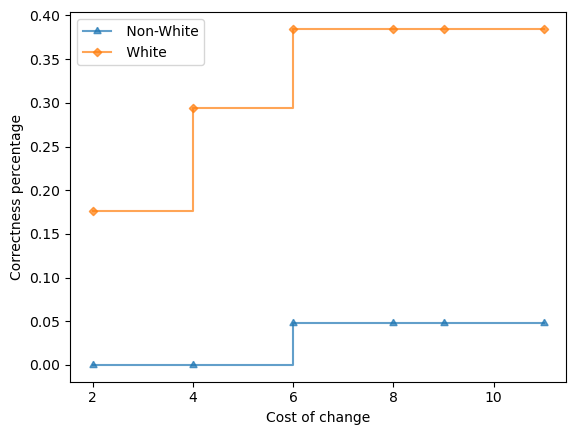

In [19]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If Workclass =  Private, capital-loss = 0, education-num = 11, hours-per-week = FullTime, sex =  Male:
	Protected Subgroup ' Non-White', 1.04% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 16.67% and counterfactual cost = 2.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 22.22% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 22.22% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, education-num = 13 with effectiveness 22.22% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 27.78% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = BrainDrain with effectiveness 27.78% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-inc, education-num = 13, hours-per-week = OverTime with effectiveness 38.89% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' White', 1.07% co

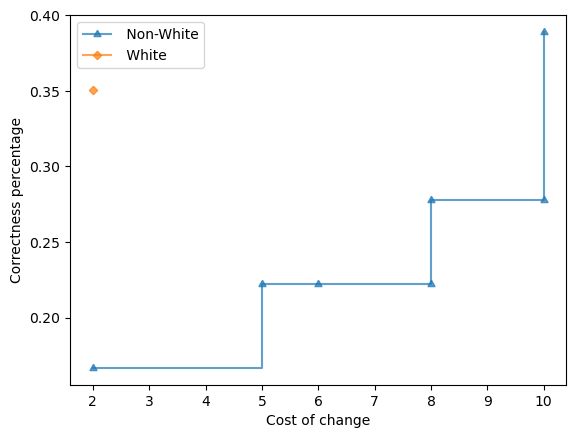

If Workclass =  Private, capital-gain = 0, education-num = 10, hours-per-week = FullTime, marital-status =  Married-civ-spouse, sex =  Male:
	Protected Subgroup ' Non-White', 2.08% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 33.33% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' White', 2.49% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 23.11% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 23.11% and counterfactual cost = 4.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 68.44% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 8.00
	Bias against  White due to Equal Effectiveness. Unfairness score = 6.0.
	Cumulative effectiveness plot for the above recourses:


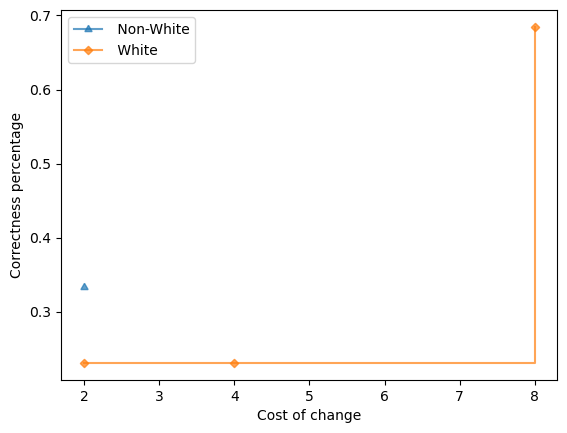

If Workclass =  Private, capital-gain = 0, education-num = 10, hours-per-week = FullTime, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.97% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 35.29% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' White', 2.48% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 23.21% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 23.21% and counterfactual cost = 4.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 68.75% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 8.00
	Bias against  White due to Equal Effectiveness. Unfairness score = 6.0.
	Cumulative effectiveness plot for the above recourses:


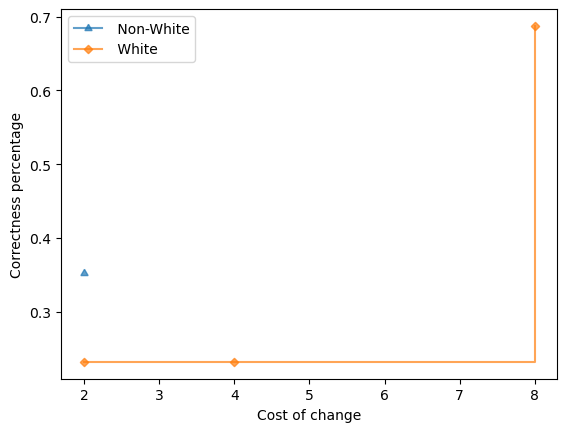

If education-num = 11, hours-per-week = FullTime, sex =  Male:
	Protected Subgroup ' Non-White', 1.51% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 15.38% and counterfactual cost = 2.0.
		Make education-num = 12 with effectiveness 15.38% and counterfactual cost = 3.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 23.08% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 23.08% and counterfactual cost = 6.0.
		Make education-num = 13, hours-per-week = MidTime with effectiveness 23.08% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 30.77% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 8.00
	Protected Subgroup ' White', 1.42% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 31.25% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Bias against  Non-White due to Equal Effectiveness.

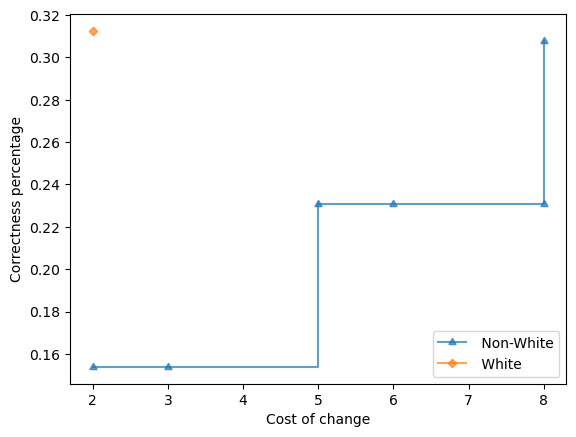

If education-num = 14, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 1.16% covered out of 1727
		Make marital-status =  Married-civ-spouse with effectiveness 10.00% and counterfactual cost = 5.0.
		Make education-num = 15, marital-status =  Married-civ-spouse with effectiveness 25.00% and counterfactual cost = 8.0.
		Make education-num = 16, marital-status =  Married-civ-spouse with effectiveness 45.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' White', 1.57% covered out of 9027
		Make marital-status =  Married-civ-spouse with effectiveness 38.73% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 5.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 6.0.
	Cumulative effectiveness plot for the above recourses:


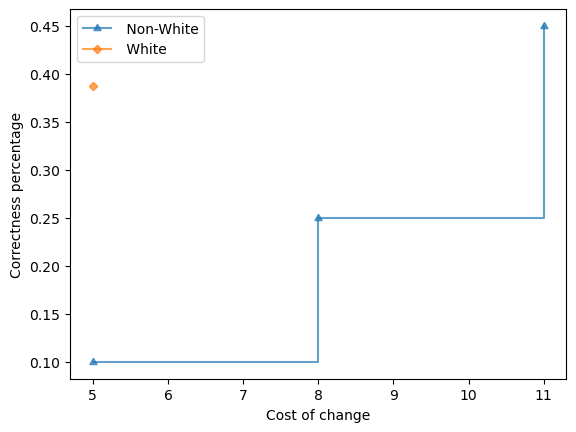

If Workclass =  Private, capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, occupation =  Prof-specialty:
	Protected Subgroup ' Non-White', 1.04% covered out of 1727
		Make marital-status =  Married-civ-spouse with effectiveness 16.67% and counterfactual cost = 5.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse with effectiveness 16.67% and counterfactual cost = 7.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 38.89% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 7.00
	Protected Subgroup ' White', 1.34% covered out of 9027
		Make marital-status =  Married-civ-spouse with effectiveness 9.92% and counterfactual cost = 5.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse with effectiveness 9.92% and counterfactual cost = 7.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 22.31% and counterfactual cost = 7.0

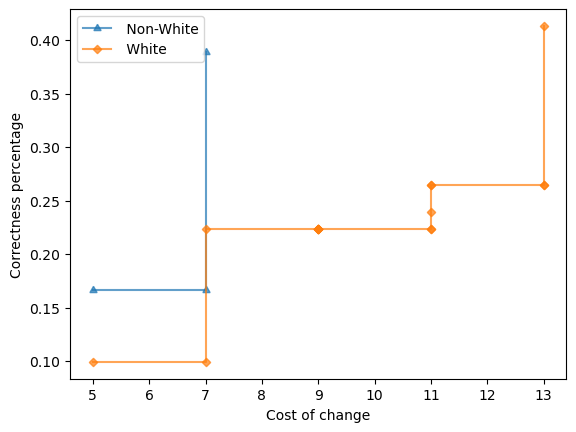

If Workclass =  Private, education-num = 10, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 3.07% covered out of 1727
		Make Workclass =  Self-emp-inc with effectiveness 16.98% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 30.19% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' White', 4.39% covered out of 9027
		Make Workclass =  Self-emp-inc with effectiveness 14.14% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 27.53% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 27.53% and counterfactual cost = 3.0.
		Make education-num = 12 with effectiveness 42.42% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 6.00
	Bias against  White due to Equal Effectiveness. Unfairness score = 4.0.
	Cumulative effectiveness plot for the above recourses:


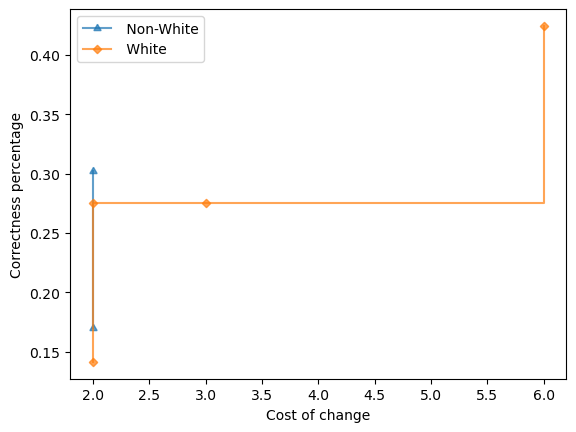

If age = (26.0, 34.0], marital-status =  Never-married, occupation =  Prof-specialty:
	Protected Subgroup ' Non-White', 1.62% covered out of 1727
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 14.29% and counterfactual cost = 15.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with effectiveness 21.43% and counterfactual cost = 15.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, occupation =  Sales with effectiveness 21.43% and counterfactual cost = 19.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, occupation =  Craft-repair with effectiveness 21.43% and counterfactual cost = 19.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, occupation =  Craft-repair with effectiveness 21.43% and counterfactual cost = 19.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, occupation =  Adm-clerical with effectiveness 21.43% and counterfactual cost = 19.0.
		Make age = (41.

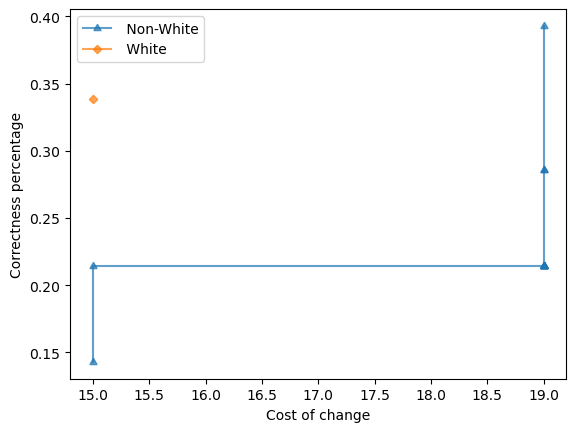

If Workclass =  Private, marital-status =  Never-married, occupation =  Adm-clerical, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.62% covered out of 1727
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 25.00% and counterfactual cost = 10.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.29% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Protected Subgroup ' White', 2.30% covered out of 9027
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 11.54% and counterfactual cost = 10.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 24.04% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 24.04% and counterfactual cost = 14.0.
		Ma

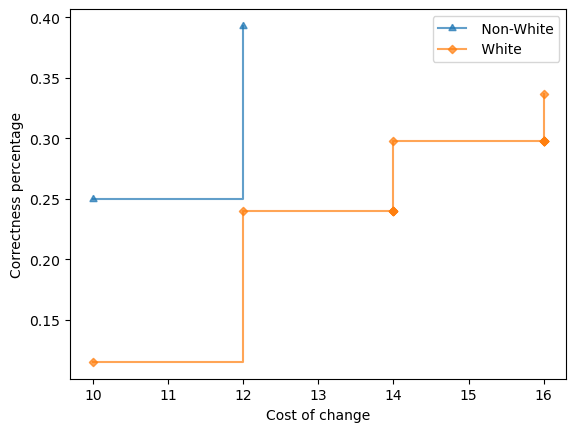

If marital-status =  Never-married, native-country =  United-States, occupation =  Sales, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.16% covered out of 1727
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 30.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' White', 2.19% covered out of 9027
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 23.23% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 23.23% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  Married with effectiveness 23.23% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with effectiveness 23.23% and counterfactual cost 

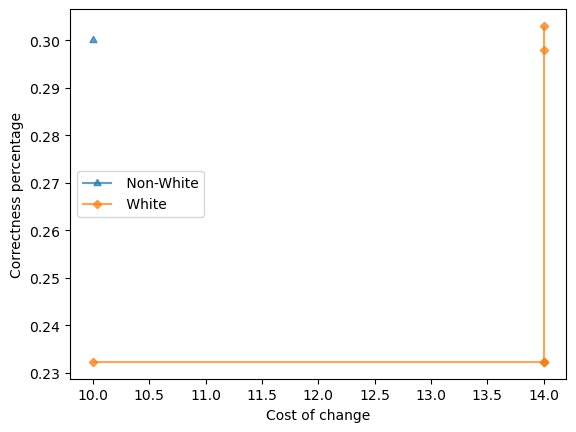

In [20]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If Workclass =  Self-emp-not-inc, capital-loss = 0, native-country =  United-States, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.04% covered out of 1727
		Make Workclass =  Local-gov with effectiveness 5.56% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 5.56% and counterfactual cost = 2.0.
		Make Workclass =  Private with effectiveness 11.11% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 22.22% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 22.22% and counterfactual cost = 2.0.
		Make Workclass =  Private, capital-loss = 1887 with effectiveness 33.33% and counterfactual cost = 2.43.
		Make Workclass =  Private, capital-loss = 1902 with effectiveness 33.33% and counterfactual cost = 2.44.
		Make Workclass =  Private, capital-loss = 1977 with effectiveness 33.33% and counterfactual cost = 2.45.
		Make Workclass =  Private, relationship =  Not-in-family w

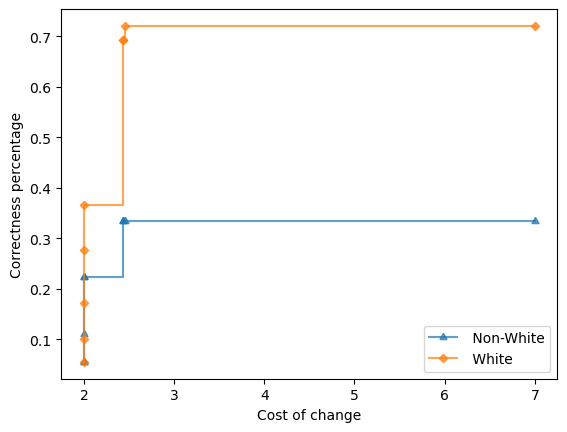

If education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Non-White', 1.51% covered out of 1727
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.69% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 7.69% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.08
	Protected Subgroup ' White', 1.21% covered out of 9027
		Make occupation =  Craft-repair with effectiveness 0.00% and counte

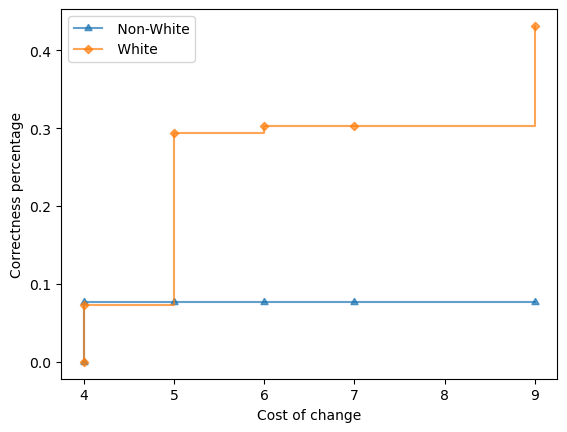

If education-num = 14, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 1.16% covered out of 1727
		Make marital-status =  Married-civ-spouse with effectiveness 10.00% and counterfactual cost = 5.0.
		Make education-num = 15, marital-status =  Married-civ-spouse with effectiveness 25.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.25
	Protected Subgroup ' White', 1.57% covered out of 9027
		Make marital-status =  Married-civ-spouse with effectiveness 38.73% and counterfactual cost = 5.0.
		Make education-num = 15, marital-status =  Married-civ-spouse with effectiveness 59.86% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.60
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.349.
	Cumulative effectiveness plot for the above recourses:


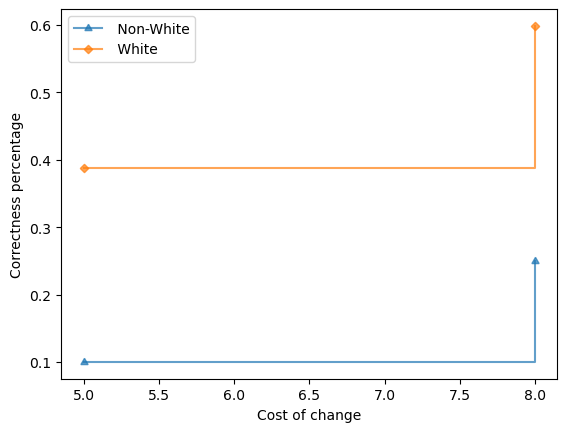

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 4.92% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.35% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.35% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.06% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 7.06% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 7.06% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 17.65% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.18
	Protected Subgroup ' White', 6.00% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.07% and counterfactual cost = 2.0.
		Make education-num = 10 with effect

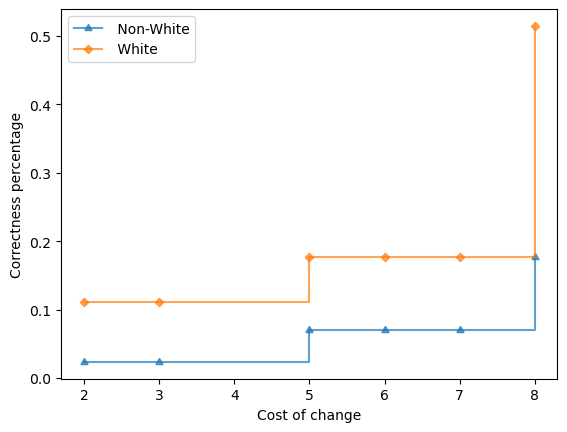

If hours-per-week = PartTime, native-country =  United-States, relationship =  Married:
	Protected Subgroup ' Non-White', 1.22% covered out of 1727
		Make hours-per-week = MidTime with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime with effectiveness 4.76% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain with effectiveness 4.76% and counterfactual cost = 8.0.
		Make hours-per-week = FullTime, relationship =  Not-in-family with effectiveness 4.76% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.05
	Protected Subgroup ' White', 2.45% covered out of 9027
		Make hours-per-week = MidTime with effectiveness 17.65% and counterfactual cost = 2.0.
		Make hours-per-week = FullTime with effectiveness 29.41% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime with effectiveness 38.46% and counterfactual cost = 6.0.
		M

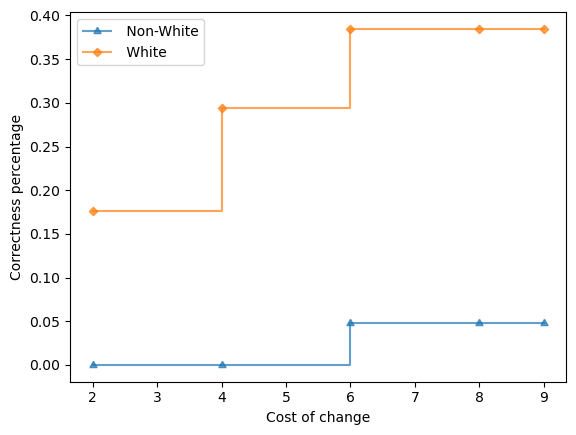

If Workclass =  Self-emp-not-inc, hours-per-week = FullTime, sex =  Male:
	Protected Subgroup ' Non-White', 1.33% covered out of 1727
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Private with effectiveness 4.35% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 4.35% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 8.70% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 8.70% and counterfactual cost = 2.0.
		Make Workclass =  Private, hours-per-week = MidTime with effectiveness 8.70% and counterfactual cost = 4.0.
		Make hours-per-week = BrainDrain with effectiveness 8.70% and counterfactual cost = 4.0.
		Make Workclass =  Private, hours-per-week = OverTime with effectiveness 8.70% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc

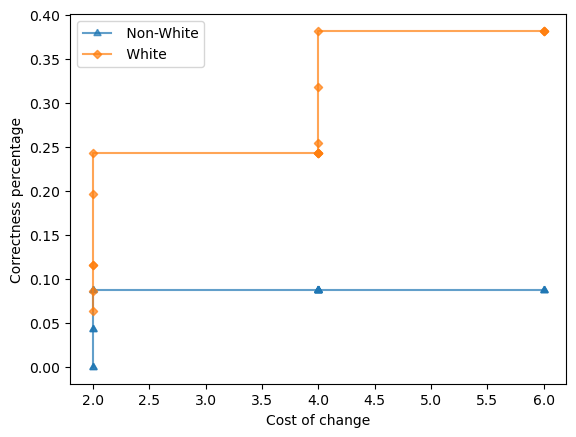

In [21]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 76.78% covered out of 1727
		Make capital-gain = 3103 with effectiveness 9.50% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 13.95% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 18.33% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 28.51% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 31.22% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 76.70% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 89.30% covered out of 9027
		Make capital-gain = 3103 with effectiveness 20.46% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 28.09% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 32.56% and count

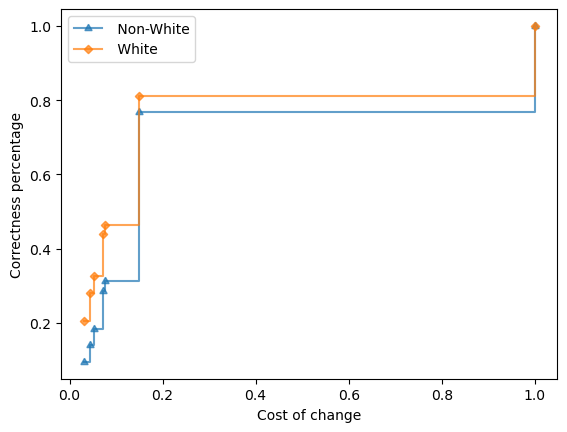

If capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 74.93% covered out of 1727
		Make capital-gain = 3103 with effectiveness 9.27% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 13.45% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 17.77% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 27.90% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 30.60% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 76.28% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 76.28% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 76.28% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 76.28% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgr

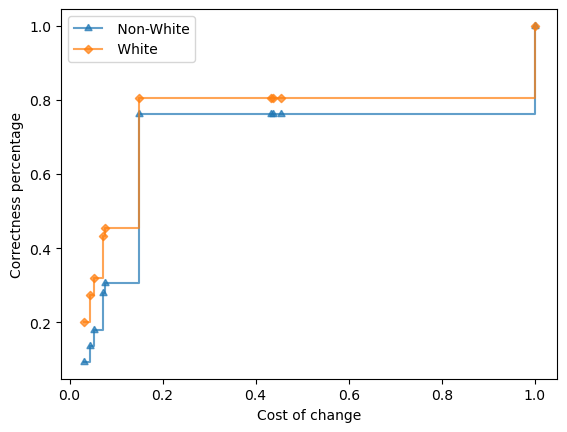

If capital-gain = 0:
	Protected Subgroup ' Non-White', 96.29% covered out of 1727
		Make capital-gain = 3103 with effectiveness 9.44% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 14.37% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 18.88% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 29.40% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 32.05% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 76.37% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 96.61% covered out of 9027
		Make capital-gain = 3103 with effectiveness 19.70% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 27.05% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 31.43% and counterfactual cost = 0.05.
		Make cap

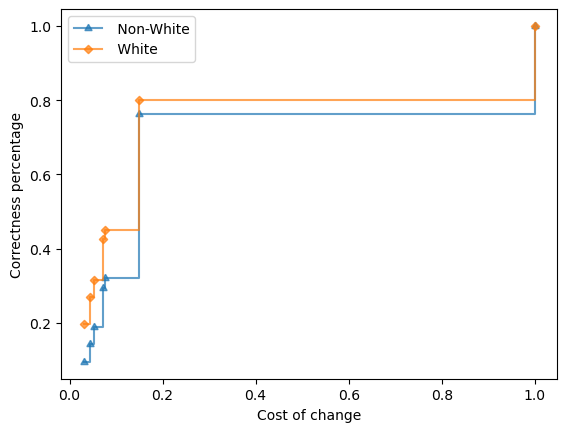

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Non-White', 94.04% covered out of 1727
		Make capital-gain = 3103 with effectiveness 9.24% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 13.85% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 18.29% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 28.76% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 31.40% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 75.92% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 75.92% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 75.92% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 75.92% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 93.74% covered out 

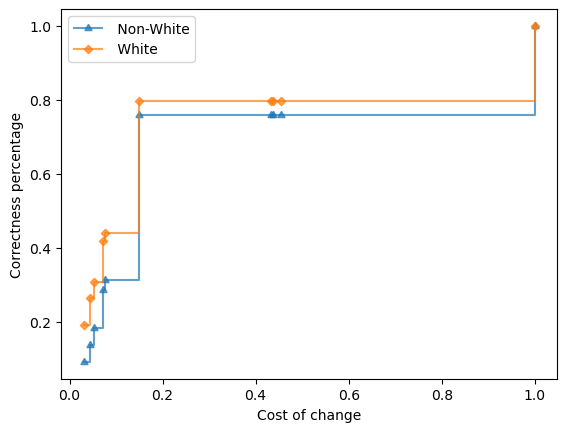

If Workclass =  Private, capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 57.56% covered out of 1727
		Make capital-gain = 7298 with effectiveness 25.15% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 27.46% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 73.44% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' White', 68.70% covered out of 9027
		Make capit

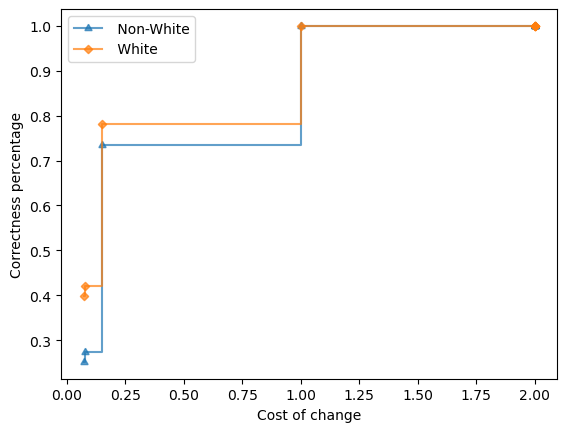

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 56.05% covered out of 1727
		Make capital-gain = 7298 with effectiveness 24.38% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 26.76% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 72.93% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 72.93% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 72.93% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 72.93% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and coun

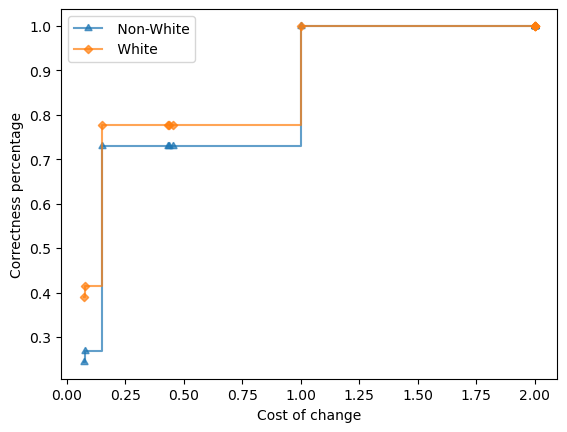

If capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 78.00% covered out of 1727
		Make capital-loss = 1887 with effectiveness 11.21% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 11.36% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 11.80% and counterfactual cost = 0.45.
	Protected Subgroup ' White', 89.71% covered out of 9027
		Make capital-loss = 1887 with effectiveness 23.30% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 23.45% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 24.15% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 4.2.
	Cumulative effectiveness plot for the above recourses:


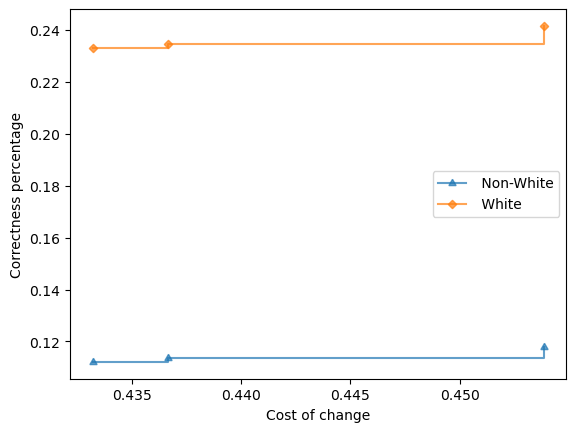

If capital-loss = 0:
	Protected Subgroup ' Non-White', 97.74% covered out of 1727
		Make capital-loss = 1887 with effectiveness 11.61% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 11.73% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 12.26% and counterfactual cost = 0.45.
	Protected Subgroup ' White', 97.13% covered out of 9027
		Make capital-loss = 1887 with effectiveness 22.45% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 22.60% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 23.30% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 4.15.
	Cumulative effectiveness plot for the above recourses:


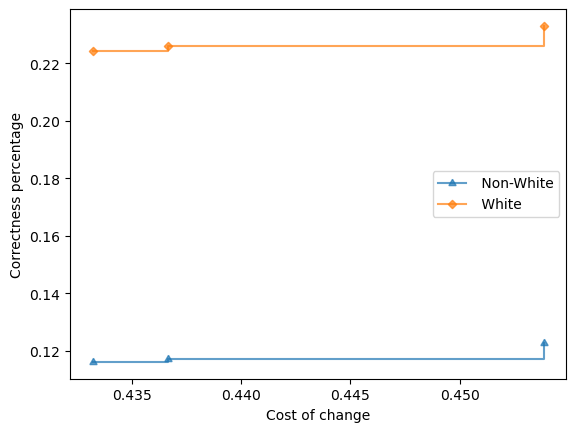

If age = (26.0, 34.0], capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 19.28% covered out of 1727
		Make age = (34.0, 41.0] with effectiveness 3.60% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 5.11% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], capital-gain = 7298 with effectiveness 35.44% and counterfactual cost = 10.07.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 40.24% and counterfactual cost = 10.08.
		Make age = (34.0, 41.0], capital-gain = 15024 with effectiveness 93.09% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 93.99% and counterfactual cost = 10.15.
	Protected Subgroup ' White', 19.83% covered out of 9027
		Make age = (34.0, 41.0] with effectiveness 7.88% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 11.01% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], capital-gain = 7298 wi

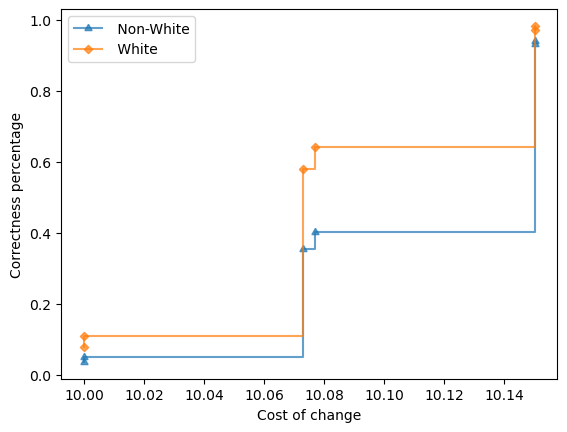

If Workclass =  Private, capital-gain = 0:
	Protected Subgroup ' Non-White', 74.35% covered out of 1727
		Make capital-gain = 7298 with effectiveness 26.40% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 28.66% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 73.21% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' White', 74.79% covered out of 9027
		Make capital-gain = 7298 with effectiveness

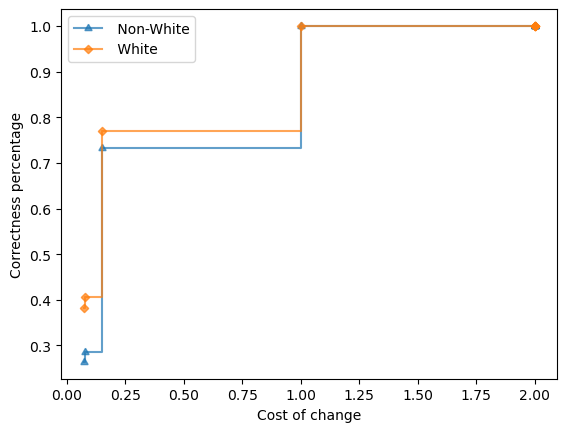

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 18.99% covered out of 1727
		Make age = (34.0, 41.0] with effectiveness 3.66% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 5.18% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], capital-gain = 7298 with effectiveness 35.06% and counterfactual cost = 10.07.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 39.94% and counterfactual cost = 10.08.
		Make age = (34.0, 41.0], capital-gain = 15024 with effectiveness 92.99% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 93.90% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 93.90% and counterfactual cost = 10.44.
	Protected Subgroup ' White', 19.20% covered out of 9027
		Make age = (34.0, 41.0] with effectiveness 7.62% and counterfactual cost = 10.0.
		Make ag

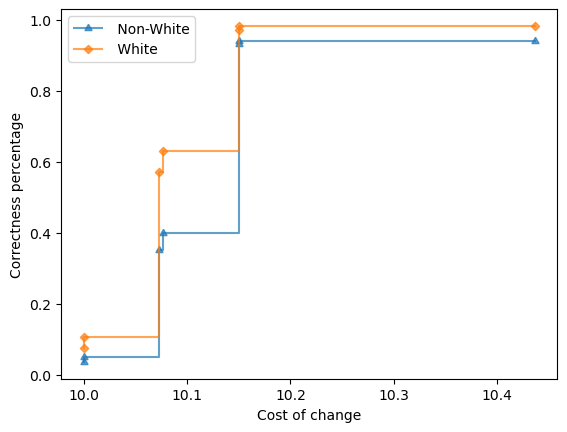

If Workclass =  Private, capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Non-White', 72.50% covered out of 1727
		Make capital-gain = 7298 with effectiveness 25.64% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 27.96% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 72.68% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 72.68% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 72.68% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 72.68% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Wor

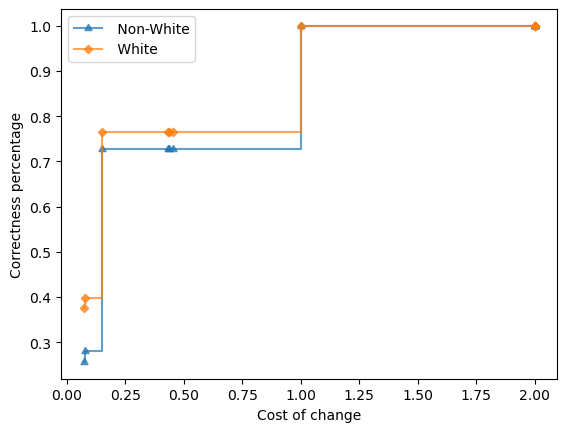

If capital-gain = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 37.87% covered out of 1727
		Make capital-gain = 3103 with effectiveness 16.21% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 22.78% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 27.98% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 38.69% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 40.98% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.82% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 56.16% covered out of 9027
		Make capital-gain = 3103 with effectiveness 28.66% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 38.01% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 43

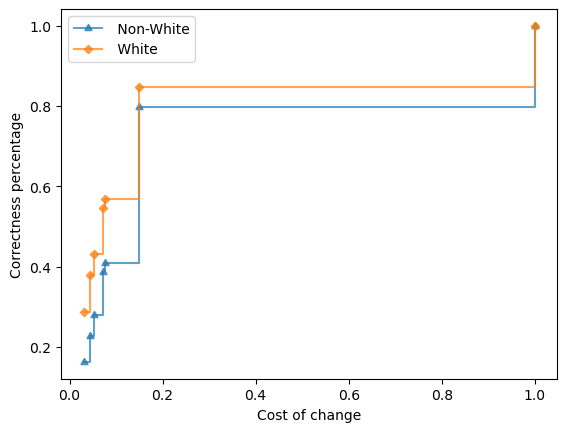

If capital-gain = 0, capital-loss = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 36.83% covered out of 1727
		Make capital-gain = 3103 with effectiveness 15.88% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 22.17% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 27.52% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 38.36% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 40.57% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.56% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 79.56% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 79.56% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 79.56% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	P

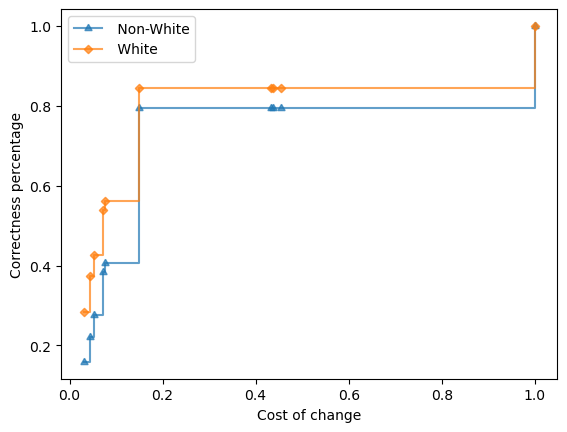

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Non-White', 46.44% covered out of 1727
		Make capital-gain = 7298 with effectiveness 31.55% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 34.16% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.29% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 82.29% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 82.29% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 82.29% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 82.29% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.15% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 89.15% and counterfactual cost =

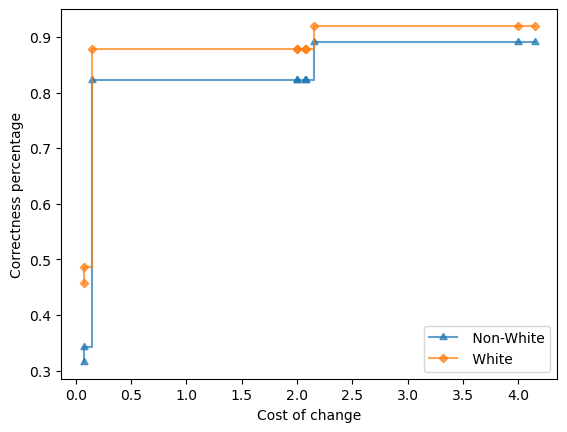

If capital-gain = 0, sex =  Male:
	Protected Subgroup ' Non-White', 49.10% covered out of 1727
		Make capital-gain = 3103 with effectiveness 15.57% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 23.00% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 28.77% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 39.27% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 41.63% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.48% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 60.95% covered out of 9027
		Make capital-gain = 3103 with effectiveness 27.44% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 36.46% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 41.51% and counterfactual cost = 0.

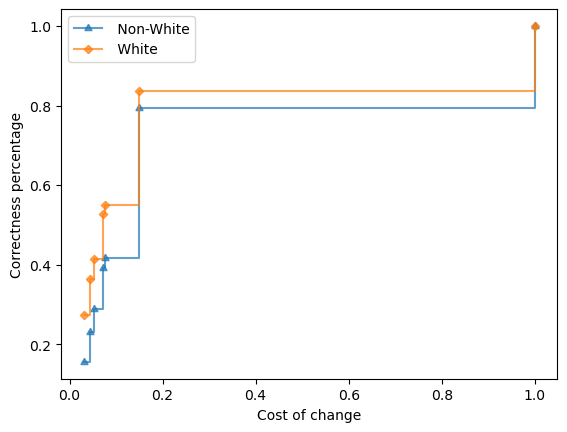

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Non-White', 45.51% covered out of 1727
		Make capital-gain = 7298 with effectiveness 30.92% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 33.59% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.93% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 81.93% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 81.93% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 81.93% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 81.93% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 81.93% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 81.93% and counterfactual cost = 2.08.
		Make capi

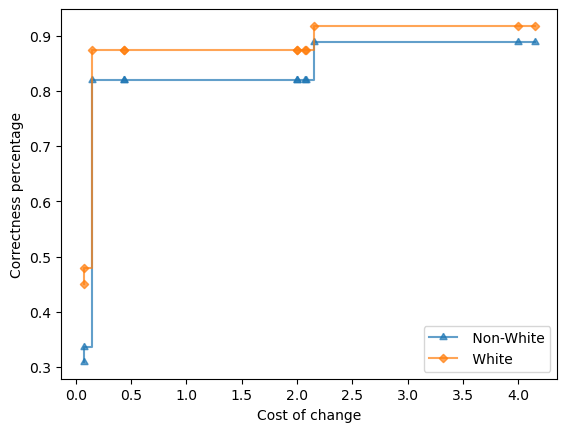

If capital-gain = 0, capital-loss = 0, sex =  Male:
	Protected Subgroup ' Non-White', 47.83% covered out of 1727
		Make capital-gain = 3103 with effectiveness 15.25% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 22.40% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 28.21% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 38.74% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 41.04% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.18% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 79.18% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 79.18% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 79.18% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 59.26

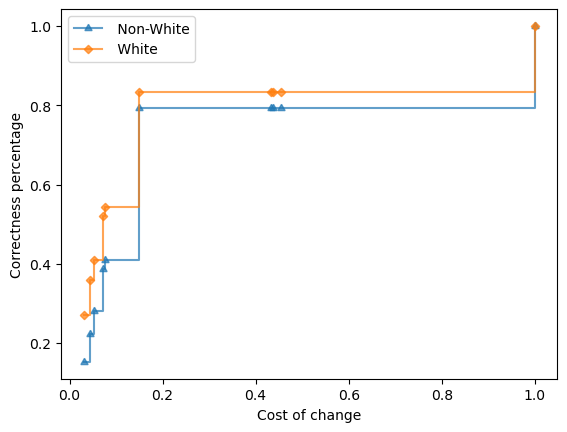

If capital-loss = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 38.10% covered out of 1727
		Make capital-loss = 1887 with effectiveness 18.24% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 18.54% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 19.00% and counterfactual cost = 0.45.
	Protected Subgroup ' White', 56.46% covered out of 9027
		Make capital-loss = 1887 with effectiveness 32.00% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 32.14% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 33.00% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.38.
	Cumulative effectiveness plot for the above recourses:


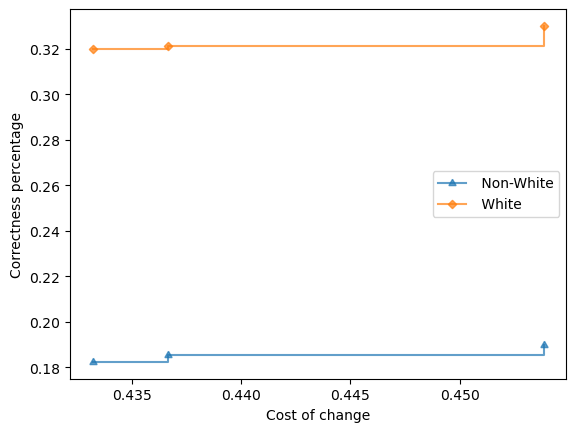

If age = (26.0, 34.0], capital-gain = 0:
	Protected Subgroup ' Non-White', 24.61% covered out of 1727
		Make age = (34.0, 41.0] with effectiveness 4.94% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 6.59% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], capital-gain = 7298 with effectiveness 38.59% and counterfactual cost = 10.07.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 44.24% and counterfactual cost = 10.08.
		Make age = (34.0, 41.0], capital-gain = 15024 with effectiveness 93.18% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 93.88% and counterfactual cost = 10.15.
	Protected Subgroup ' White', 21.65% covered out of 9027
		Make age = (34.0, 41.0] with effectiveness 7.47% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 10.39% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], capital-gain = 7298 with effectiveness 55.94% and count

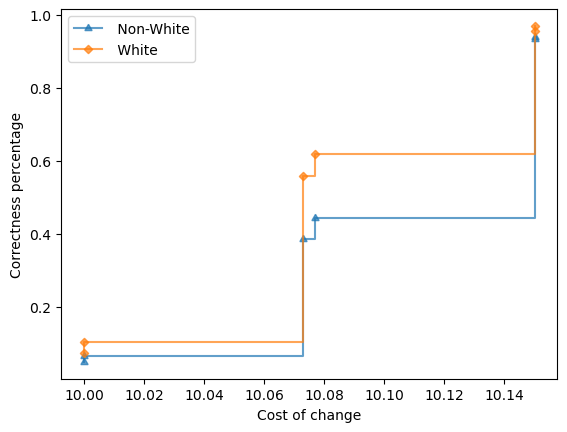

If capital-loss = 0, sex =  Male:
	Protected Subgroup ' Non-White', 49.62% covered out of 1727
		Make capital-loss = 1887 with effectiveness 18.67% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 18.90% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 19.60% and counterfactual cost = 0.45.
	Protected Subgroup ' White', 61.40% covered out of 9027
		Make capital-loss = 1887 with effectiveness 30.67% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.83% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 31.70% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.3.
	Cumulative effectiveness plot for the above recourses:


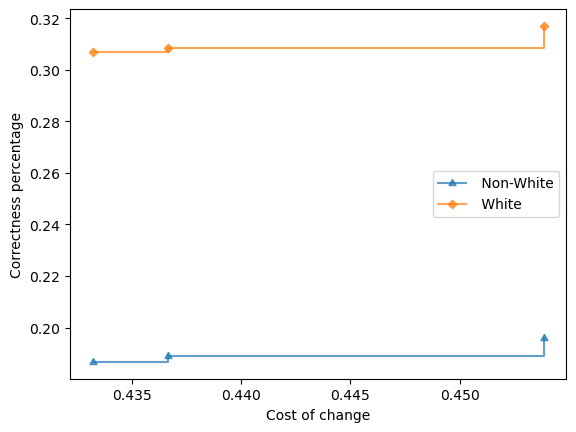

If Workclass =  Private, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 58.31% covered out of 1727
		Make capital-loss = 1887 with effectiveness 10.23% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 10.43% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 10.72% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 10.72% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 10.72% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 10.72% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 10.72% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 10.72% and counterfactual cost = 2.0.
	Protected Subgroup ' White', 69.05% covered out of 9027
		Make capital-loss = 1887 with effectiveness 21.08% and counterfactual cost = 0.43.
		Make capital-loss

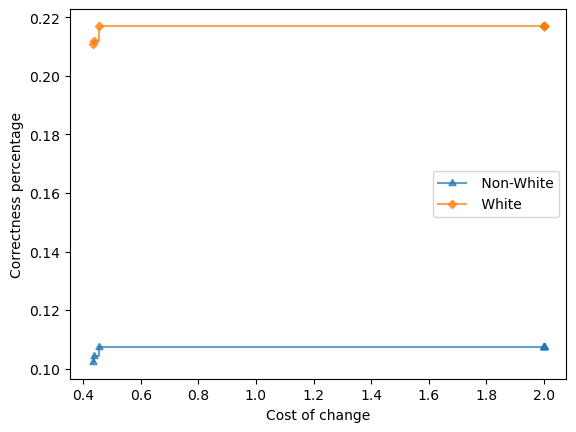

If Workclass =  Private, capital-gain = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 28.95% covered out of 1727
		Make capital-gain = 7298 with effectiveness 36.00% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 37.80% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 77.20% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' White', 42.23% covered out of 9027

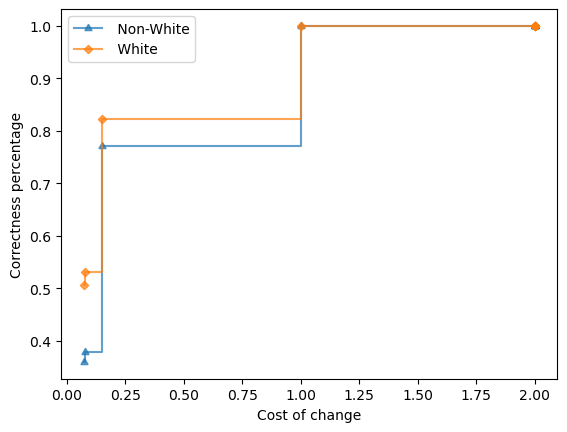

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Non-White', 24.09% covered out of 1727
		Make age = (34.0, 41.0] with effectiveness 4.81% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 6.49% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], capital-gain = 7298 with effectiveness 37.98% and counterfactual cost = 10.07.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 43.51% and counterfactual cost = 10.08.
		Make age = (34.0, 41.0], capital-gain = 15024 with effectiveness 93.03% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 93.75% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 93.75% and counterfactual cost = 10.44.
	Protected Subgroup ' White', 20.99% covered out of 9027
		Make age = (34.0, 41.0] with effectiveness 7.23% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectivene

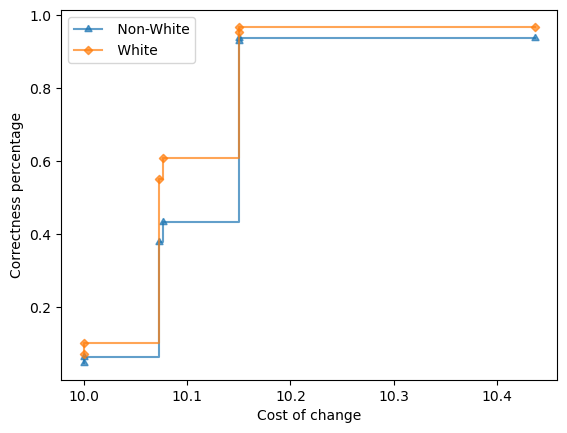

If age = (34.0, 41.0], capital-loss = 0:
	Protected Subgroup ' Non-White', 17.54% covered out of 1727
		Make age = (50.0, 90.0] with effectiveness 0.33% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 0.99% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 18.15% and counterfactual cost = 10.44.
	Protected Subgroup ' White', 15.75% covered out of 9027
		Make age = (50.0, 90.0] with effectiveness 1.20% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 4.36% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 38.26% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.18.
	Cumulative effectiveness plot for the above recourses:


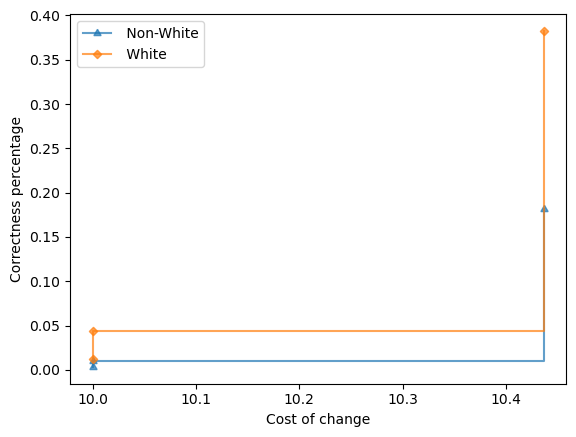

If Workclass =  Private, capital-loss = 0:
	Protected Subgroup ' Non-White', 75.28% covered out of 1727
		Make capital-loss = 1887 with effectiveness 10.62% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 10.77% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 11.23% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 11.23% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 11.23% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 11.23% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 11.23% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 11.23% and counterfactual cost = 2.0.
	Protected Subgroup ' White', 75.21% covered out of 9027
		Make capital-loss = 1887 with effectiveness 20.19% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 20.31%

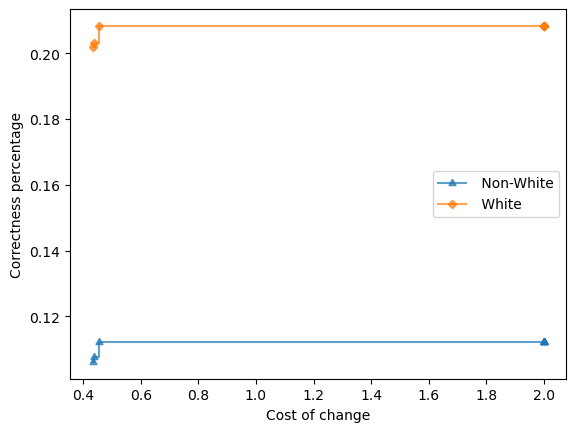

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 28.08% covered out of 1727
		Make capital-gain = 7298 with effectiveness 35.46% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 37.32% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 76.91% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 76.91% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 76.91% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 76.91% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100

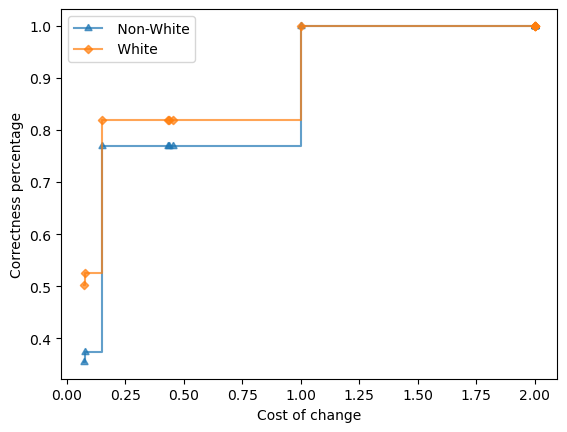

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Non-White', 47.42% covered out of 1727
		Make capital-loss = 1887 with effectiveness 11.72% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 11.84% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 11.84% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 11.84% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 11.84% and counterfactual cost = 4.0.
	Protected Subgroup ' White', 42.87% covered out of 9027
		Make capital-loss = 1887 with effectiveness 23.72% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 23.95% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 23.95% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 23.95% and counterfactual cost = 2.0.
		Make hour

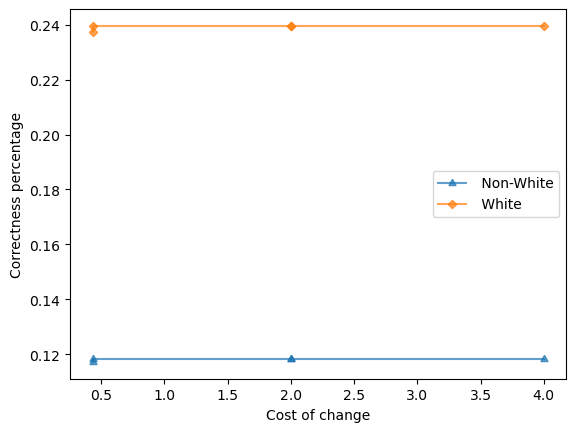

If capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Non-White', 57.85% covered out of 1727
		Make capital-gain = 7298 with effectiveness 32.83% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 35.54% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.38% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 81.38% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 81.38% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 81.38% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 81.38% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 88.09% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 88.09% and counterfactual cost = 4.0.
		Make capital-gain = 15024

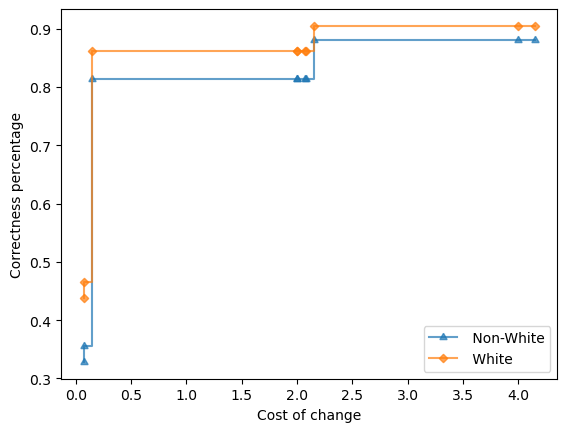

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 5.91% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 1.96% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 1.96% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 5.88% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 5.88% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 5.88% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 17.65% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.85% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.17% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 11.17% and counterfactual cost = 3.0.
	

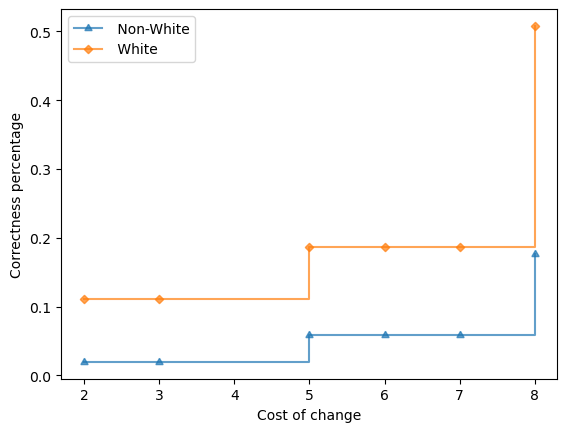

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 14.07% covered out of 1727
		Make age = (50.0, 90.0] with effectiveness 0.41% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 1.23% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 17.70% and counterfactual cost = 10.44.
	Protected Subgroup ' White', 14.52% covered out of 9027
		Make age = (50.0, 90.0] with effectiveness 1.07% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 4.35% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 39.13% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.07.
	Cumulative effectiveness plot for the above recourses:


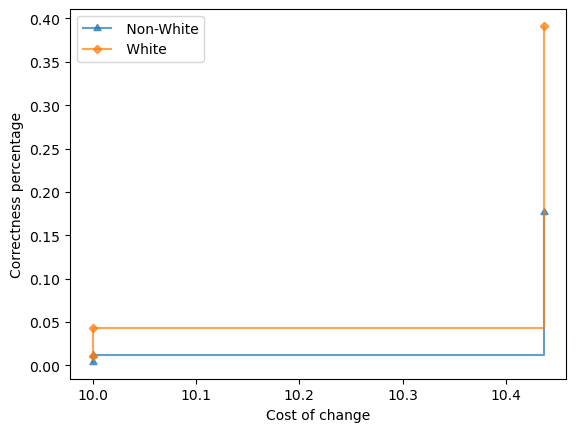

If Workclass =  Private, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 6.02% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.88% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.88% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.69% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 7.69% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 7.69% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 19.23% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.97% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 12.24% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 12.24% and counterfactual cost = 3.0.
		Make education-nu

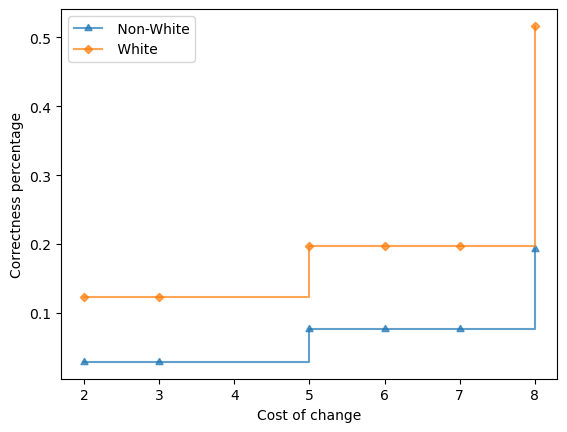

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Non-White', 56.69% covered out of 1727
		Make capital-gain = 7298 with effectiveness 32.18% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 34.93% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.00% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 81.00% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 81.00% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 81.00% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 81.00% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 81.00% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 81.00% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week 

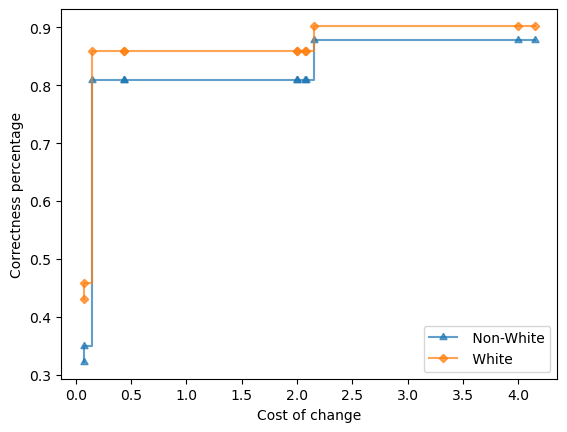

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married:
	Protected Subgroup ' Non-White', 5.67% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.04% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.04% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.12% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 6.12% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 6.12% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 18.37% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.74% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.35% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 11.35% and cou

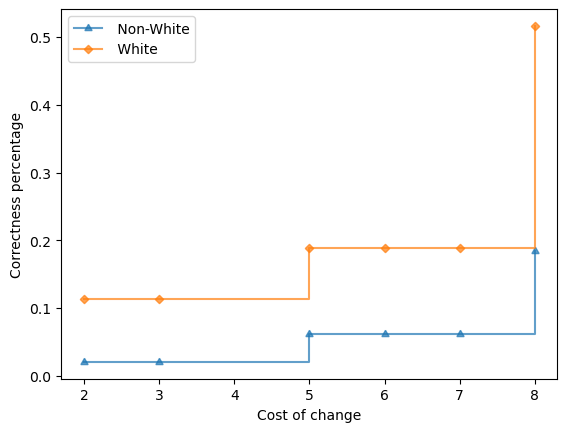

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, relationship =  Married:
	Protected Subgroup ' Non-White', 5.67% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.04% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.04% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.12% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 6.12% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 6.12% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 18.37% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.74% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.35% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 11.35% and counterfactual cost = 3.0.
		Make educati

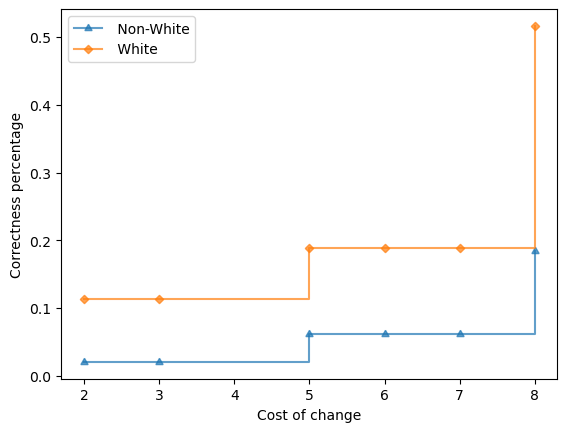

If capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Non-White', 59.00% covered out of 1727
		Make capital-loss = 1887 with effectiveness 12.17% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 12.27% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 12.27% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 12.27% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 12.27% and counterfactual cost = 4.0.
	Protected Subgroup ' White', 47.08% covered out of 9027
		Make capital-loss = 1887 with effectiveness 22.64% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 22.87% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 22.87% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 22.87% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effe

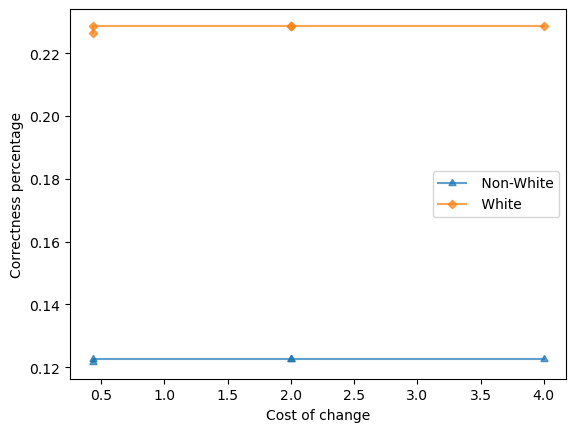

If capital-gain = 0, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 23.68% covered out of 1727
		Make capital-gain = 3103 with effectiveness 34.23% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 49.63% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 61.86% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 80.20% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 84.84% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 99.51% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 34.82% covered out of 9027
		Make capital-gain = 3103 with effectiveness 50.14% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 64.97% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 72.45% and

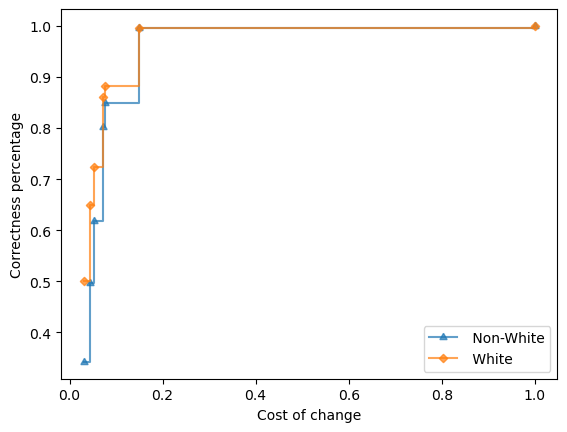

If Workclass =  Private, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married:
	Protected Subgroup ' Non-White', 5.79% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 3.00% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.00% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 8.00% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 8.00% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 8.00% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 20.00% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.86% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 12.44% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 12.44% and counterfactual cost =

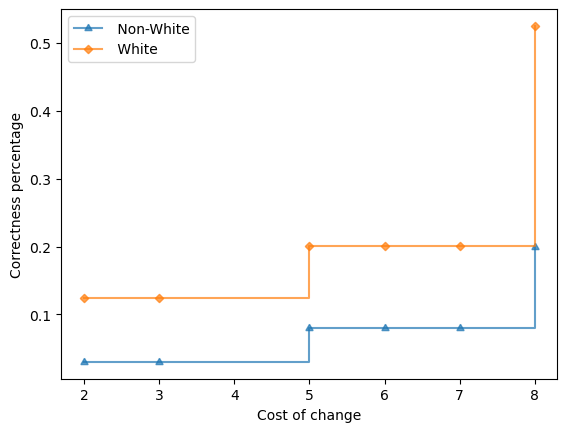

If Workclass =  Private, education-num = 9, hours-per-week = FullTime, relationship =  Married:
	Protected Subgroup ' Non-White', 5.79% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 3.00% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.00% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 8.00% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 8.00% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 8.00% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 20.00% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.86% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 12.44% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 12.44% and counterfactual cost = 3.0.
		Make education-num = 10, hours

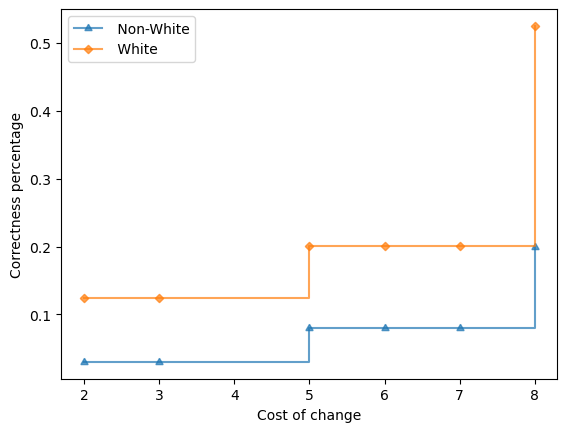

If Workclass =  Private, capital-gain = 0, sex =  Male:
	Protected Subgroup ' Non-White', 38.56% covered out of 1727
		Make capital-gain = 7298 with effectiveness 36.49% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 38.29% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 76.73% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' White', 46.32% covered out of 9027
		Make capital-gain = 7298 with 

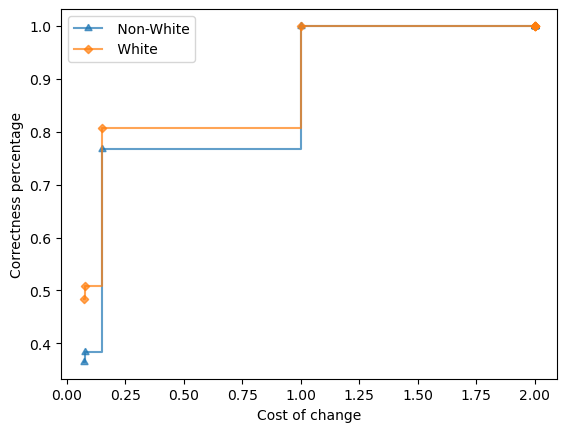

If Workclass =  Private, capital-gain = 0, capital-loss = 0, sex =  Male:
	Protected Subgroup ' Non-White', 37.52% covered out of 1727
		Make capital-gain = 7298 with effectiveness 35.80% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 37.65% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 76.39% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 76.39% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 76.39% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 76.39% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.

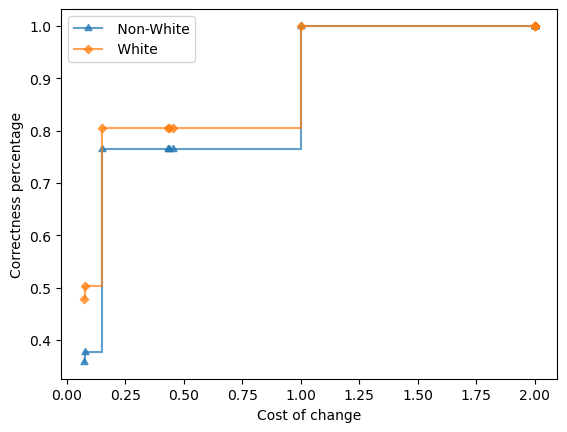

If capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 23.34% covered out of 1727
		Make capital-gain = 3103 with effectiveness 33.75% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 49.13% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 61.29% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 79.90% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 84.62% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 99.50% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 99.50% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 99.50% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 99.50% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected

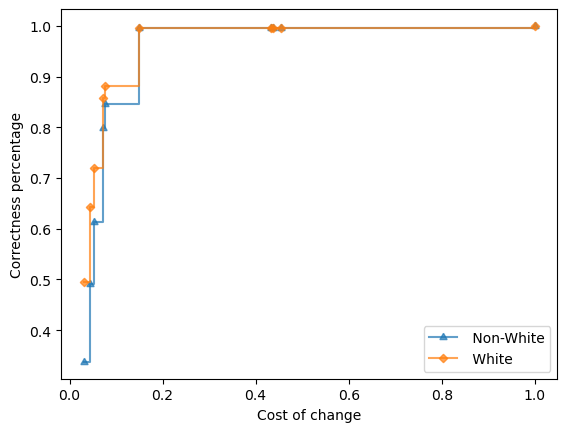

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, sex =  Male:
	Protected Subgroup ' Non-White', 5.04% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.30% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.30% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.90% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 6.90% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 6.90% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 17.24% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.08% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 10.93% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 10.93% and counterfactual 

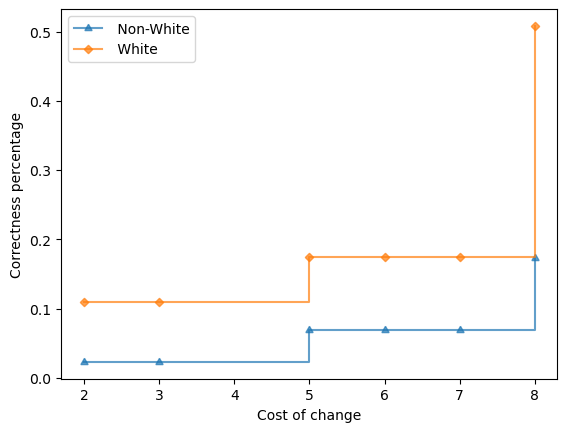

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 4.92% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.35% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.35% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.06% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 7.06% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 7.06% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 17.65% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.00% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.07% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 11.07% and counterfactual cost = 3.0.
	

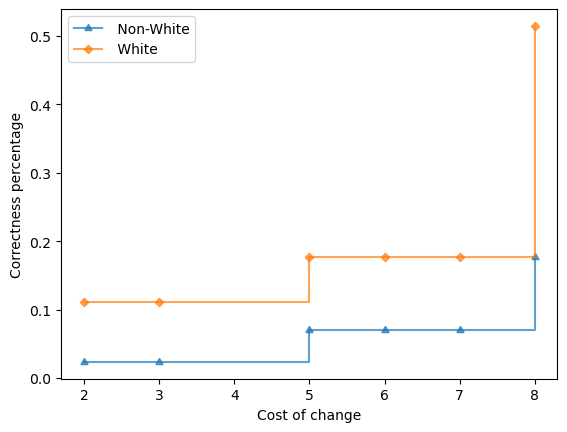

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 4.92% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 2.35% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.35% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.06% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 7.06% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 7.06% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 17.65% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.00% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 11.07% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 1

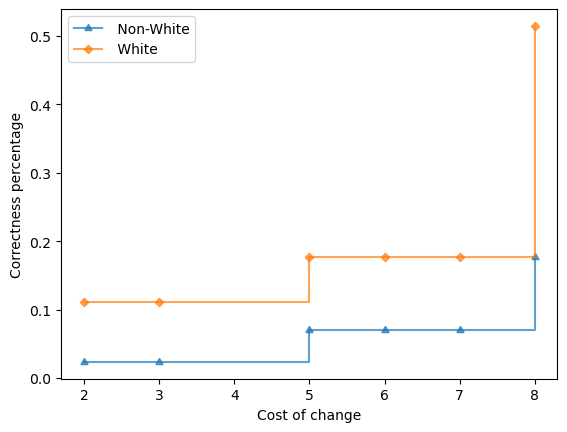

If age = (34.0, 41.0], capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 14.13% covered out of 1727
		Make age = (50.0, 90.0] with effectiveness 0.41% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 1.23% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 45.49% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 96.72% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 97.54% and counterfactual cost = 10.15.
	Protected Subgroup ' White', 14.42% covered out of 9027
		Make age = (50.0, 90.0] with effectiveness 1.00% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 4.45% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 65.67% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 wi

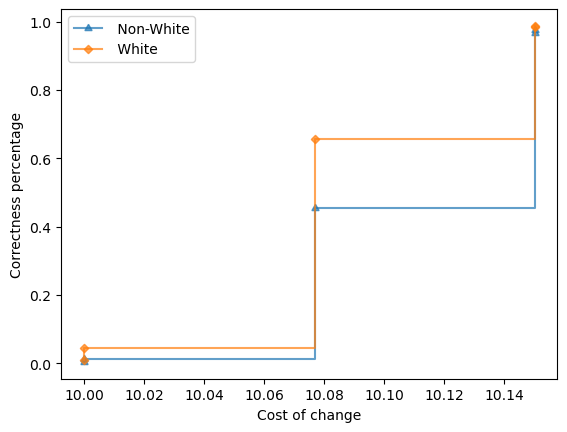

If age = (26.0, 34.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 19.69% covered out of 1727
		Make age = (34.0, 41.0] with effectiveness 3.53% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 5.59% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 20.59% and counterfactual cost = 10.44.
	Protected Subgroup ' White', 19.95% covered out of 9027
		Make age = (34.0, 41.0] with effectiveness 8.05% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 11.44% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 37.65% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.88.
	Cumulative effectiveness plot for the above recourses:


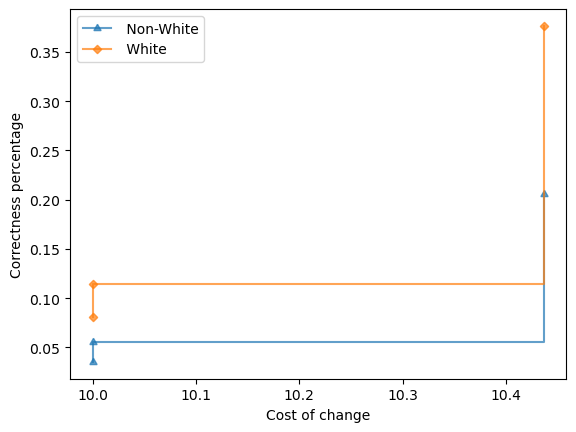

If Workclass =  Private, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, sex =  Male:
	Protected Subgroup ' Non-White', 5.15% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 3.37% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.37% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 8.99% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 8.99% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 8.99% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 19.10% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.19% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 12.16% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 12.16% and counterfactual cost = 3.0.
		Make

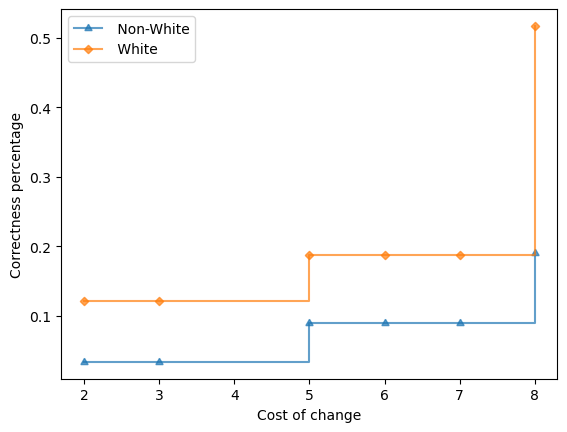

If capital-gain = 0, marital-status =  Married-civ-spouse, relationship =  Married:
	Protected Subgroup ' Non-White', 22.58% covered out of 1727
		Make capital-gain = 3103 with effectiveness 35.64% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 51.79% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 63.59% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 81.79% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 86.15% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 99.74% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 34.09% covered out of 9027
		Make capital-gain = 3103 with effectiveness 50.99% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 66.01% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with

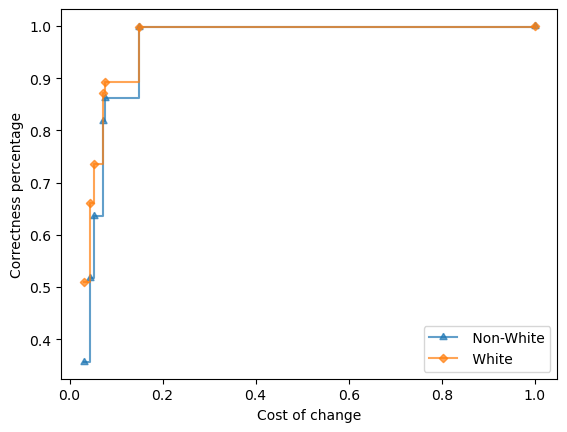

If Workclass =  Private, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 5.04% covered out of 1727
		Make hours-per-week = OverTime with effectiveness 3.45% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.45% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 9.20% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 9.20% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = BrainDrain with effectiveness 9.20% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = OverTime with effectiveness 19.54% and counterfactual cost = 8.0.
	Protected Subgroup ' White', 6.11% covered out of 9027
		Make hours-per-week = OverTime with effectiveness 12.32% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 12.32% and counterf

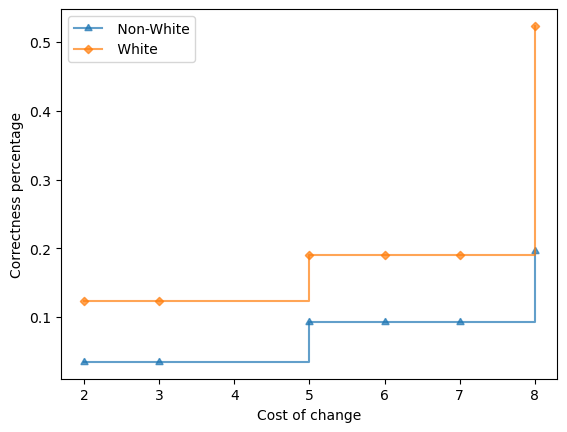

In [22]:
affected_pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

In [23]:
end_time = time.time()

In [24]:
end_time - start_time

25.740253448486328

In [25]:
stats["metrics-time"] = end_time - start_time

In [26]:
stats

{'freq-itemsets-no': {' Non-White': 24664, ' White': 27767},
 'inter-groups-no': 18692,
 'unaff-freq-itemsets-no': 56394,
 'triples-no': 112879,
 'subgroup-no': 15672,
 'valid-if-thens-time': 1488.7658200263977,
 'cumulative-time': 694.3198013305664,
 'metrics-time': 25.740253448486328}

In [27]:
stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]

2208.8258748054504